<a href="https://colab.research.google.com/github/Curiousss/EVA/blob/master/Phase2/Session5/EVAP2S5_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-10, 10), fill=(0,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [0]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=0, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

torch.Size([128, 1, 28, 28])
torch.Size([128])


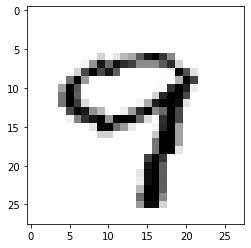

In [5]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
'''
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))
'''
dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

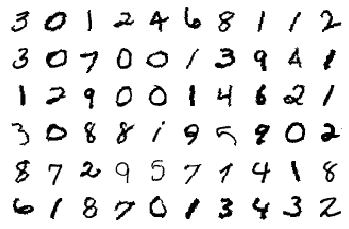

In [6]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# The model
Let's start with the model we first saw

In [7]:
'''
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout(0.1)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(0.1)
        ) # output_size = 24
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(0.1)
        ) # output_size = 22

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=32, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout(0.1)
        ) # output_size = 11

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(0.1)
        ) # output_size = 9
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(0.1)
        ) # output_size = 7

        # OUTPUT BLOCK
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.Dropout(0.1)
        ) # output_size = 7
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(7, 7), padding=0, bias=False),
            # nn.ReLU() NEVER!
        ) # output_size = 1

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)
'''

'\nclass Net(nn.Module):\n    def __init__(self):\n        super(Net, self).__init__()\n        # Input Block\n        self.convblock1 = nn.Sequential(\n            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),\n            nn.BatchNorm2d(32),\n            nn.ReLU(),\n            nn.Dropout(0.1)\n        ) # output_size = 26\n\n        # CONVOLUTION BLOCK 1\n        self.convblock2 = nn.Sequential(\n            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=0, bias=False),\n            nn.BatchNorm2d(64),\n            nn.ReLU(),\n            nn.Dropout(0.1)\n        ) # output_size = 24\n        self.convblock3 = nn.Sequential(\n            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=0, bias=False),\n            nn.BatchNorm2d(128),\n            nn.ReLU(),\n            nn.Dropout(0.1)\n        ) # output_size = 22\n\n        # TRANSITION BLOCK 1\n        self.pool1 = nn.MaxPool2d(2, 2) # output_

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Dropout(0.1)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(0.1)
        ) # output_size = 24
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=24, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(24),
            nn.ReLU(),
            nn.Dropout(0.1)
        ) # output_size = 22

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=24, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.Dropout(0.1)
        ) # output_size = 11

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(0.1)
        ) # output_size = 9
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=24, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(24),
            nn.ReLU(),
            nn.Dropout(0.1)
        ) # output_size = 7

        # OUTPUT BLOCK
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=24, out_channels=8, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Dropout(0.1)
        ) # output_size = 7
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=10, kernel_size=(7, 7), padding=0, bias=False),
            # nn.ReLU() NEVER!
        ) # output_size = 1

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [9]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
       BatchNorm2d-2            [-1, 8, 26, 26]              16
              ReLU-3            [-1, 8, 26, 26]               0
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,152
       BatchNorm2d-6           [-1, 16, 24, 24]              32
              ReLU-7           [-1, 16, 24, 24]               0
           Dropout-8           [-1, 16, 24, 24]               0
            Conv2d-9           [-1, 24, 22, 22]           3,456
      BatchNorm2d-10           [-1, 24, 22, 22]              48
             ReLU-11           [-1, 24, 22, 22]               0
          Dropout-12           [-1, 24, 22, 22]               0
        MaxPool2d-13           [-1, 24, 11, 11]               0
           Conv2d-14           [-1

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [11]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=6, gamma=0.1)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    print('Epoch:', epoch,'LR:', scheduler.get_lr())
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)
    scheduler.step()

Loss=2.1188840866088867 Batch_id=2 Accuracy=21.88:   1%|          | 3/469 [00:00<00:15, 29.40it/s]

EPOCH: 0
Epoch: 0 LR: [0.1]


Loss=0.0973731279373169 Batch_id=468 Accuracy=94.31: 100%|██████████| 469/469 [00:16<00:00, 29.31it/s]
Loss=0.06381694227457047 Batch_id=4 Accuracy=98.28:   1%|          | 3/469 [00:00<00:16, 27.94it/s]


Test set: Average loss: 0.0492, Accuracy: 9846/10000 (98.46%)

EPOCH: 1
Epoch: 1 LR: [0.1]


Loss=0.020808666944503784 Batch_id=468 Accuracy=97.40: 100%|██████████| 469/469 [00:15<00:00, 29.60it/s]
Loss=0.042537037283182144 Batch_id=5 Accuracy=98.31:   1%|          | 4/469 [00:00<00:14, 31.81it/s]


Test set: Average loss: 0.0373, Accuracy: 9881/10000 (98.81%)

EPOCH: 2
Epoch: 2 LR: [0.1]


Loss=0.05594124272465706 Batch_id=468 Accuracy=97.86: 100%|██████████| 469/469 [00:16<00:00, 28.44it/s]
Loss=0.03960321098566055 Batch_id=5 Accuracy=98.70:   1%|          | 4/469 [00:00<00:14, 32.25it/s]


Test set: Average loss: 0.0300, Accuracy: 9901/10000 (99.01%)

EPOCH: 3
Epoch: 3 LR: [0.1]


Loss=0.16076414287090302 Batch_id=468 Accuracy=98.06: 100%|██████████| 469/469 [00:16<00:00, 28.65it/s]
Loss=0.03278624638915062 Batch_id=5 Accuracy=97.92:   1%|          | 4/469 [00:00<00:14, 32.52it/s]


Test set: Average loss: 0.0354, Accuracy: 9886/10000 (98.86%)

EPOCH: 4
Epoch: 4 LR: [0.1]


Loss=0.04558061063289642 Batch_id=468 Accuracy=98.26: 100%|██████████| 469/469 [00:16<00:00, 28.98it/s]
Loss=0.02623310312628746 Batch_id=4 Accuracy=98.91:   1%|          | 3/469 [00:00<00:18, 25.59it/s]


Test set: Average loss: 0.0289, Accuracy: 9914/10000 (99.14%)

EPOCH: 5
Epoch: 5 LR: [0.1]


Loss=0.03347361460328102 Batch_id=468 Accuracy=98.33: 100%|██████████| 469/469 [00:17<00:00, 27.56it/s]
Loss=0.03278149291872978 Batch_id=4 Accuracy=98.28:   1%|          | 3/469 [00:00<00:17, 26.83it/s] 


Test set: Average loss: 0.0283, Accuracy: 9911/10000 (99.11%)

EPOCH: 6
Epoch: 6 LR: [0.0010000000000000002]


Loss=0.027969321236014366 Batch_id=468 Accuracy=98.67: 100%|██████████| 469/469 [00:16<00:00, 28.65it/s]
Loss=0.013894375413656235 Batch_id=5 Accuracy=98.83:   1%|          | 4/469 [00:00<00:14, 32.23it/s]


Test set: Average loss: 0.0207, Accuracy: 9930/10000 (99.30%)

EPOCH: 7
Epoch: 7 LR: [0.010000000000000002]


Loss=0.026221036911010742 Batch_id=468 Accuracy=98.77: 100%|██████████| 469/469 [00:16<00:00, 28.79it/s]
Loss=0.024586327373981476 Batch_id=4 Accuracy=99.06:   1%|          | 3/469 [00:00<00:16, 28.98it/s]


Test set: Average loss: 0.0200, Accuracy: 9928/10000 (99.28%)

EPOCH: 8
Epoch: 8 LR: [0.010000000000000002]


Loss=0.053356971591711044 Batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:16<00:00, 29.01it/s]
Loss=0.023988012224435806 Batch_id=4 Accuracy=99.22:   1%|          | 3/469 [00:00<00:18, 25.67it/s]


Test set: Average loss: 0.0204, Accuracy: 9927/10000 (99.27%)

EPOCH: 9
Epoch: 9 LR: [0.010000000000000002]


Loss=0.12128139287233353 Batch_id=468 Accuracy=98.88: 100%|██████████| 469/469 [00:16<00:00, 28.10it/s]
Loss=0.008377887308597565 Batch_id=4 Accuracy=99.22:   1%|          | 3/469 [00:00<00:17, 26.46it/s]


Test set: Average loss: 0.0194, Accuracy: 9933/10000 (99.33%)

EPOCH: 10
Epoch: 10 LR: [0.010000000000000002]


Loss=0.009732961654663086 Batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:15<00:00, 28.80it/s]
Loss=0.04535651206970215 Batch_id=4 Accuracy=98.28:   1%|          | 3/469 [00:00<00:16, 27.45it/s]


Test set: Average loss: 0.0190, Accuracy: 9931/10000 (99.31%)

EPOCH: 11
Epoch: 11 LR: [0.010000000000000002]


Loss=0.007697378750890493 Batch_id=468 Accuracy=98.91: 100%|██████████| 469/469 [00:15<00:00, 29.85it/s]
Loss=0.027184028178453445 Batch_id=4 Accuracy=99.38:   1%|          | 3/469 [00:00<00:16, 27.76it/s]


Test set: Average loss: 0.0194, Accuracy: 9928/10000 (99.28%)

EPOCH: 12
Epoch: 12 LR: [0.00010000000000000003]


Loss=0.0067030987702310085 Batch_id=468 Accuracy=98.83: 100%|██████████| 469/469 [00:16<00:00, 29.19it/s]
Loss=0.07105157524347305 Batch_id=4 Accuracy=98.59:   1%|          | 3/469 [00:00<00:18, 25.43it/s]


Test set: Average loss: 0.0190, Accuracy: 9934/10000 (99.34%)

EPOCH: 13
Epoch: 13 LR: [0.0010000000000000002]


Loss=0.017175892367959023 Batch_id=468 Accuracy=98.86: 100%|██████████| 469/469 [00:15<00:00, 29.49it/s]
Loss=0.07425877451896667 Batch_id=4 Accuracy=98.75:   1%|          | 3/469 [00:00<00:18, 25.44it/s]


Test set: Average loss: 0.0189, Accuracy: 9933/10000 (99.33%)

EPOCH: 14
Epoch: 14 LR: [0.0010000000000000002]


Loss=0.03694159910082817 Batch_id=468 Accuracy=98.90: 100%|██████████| 469/469 [00:15<00:00, 32.88it/s]



Test set: Average loss: 0.0187, Accuracy: 9932/10000 (99.32%)



Text(0.5, 1.0, 'Test Accuracy')

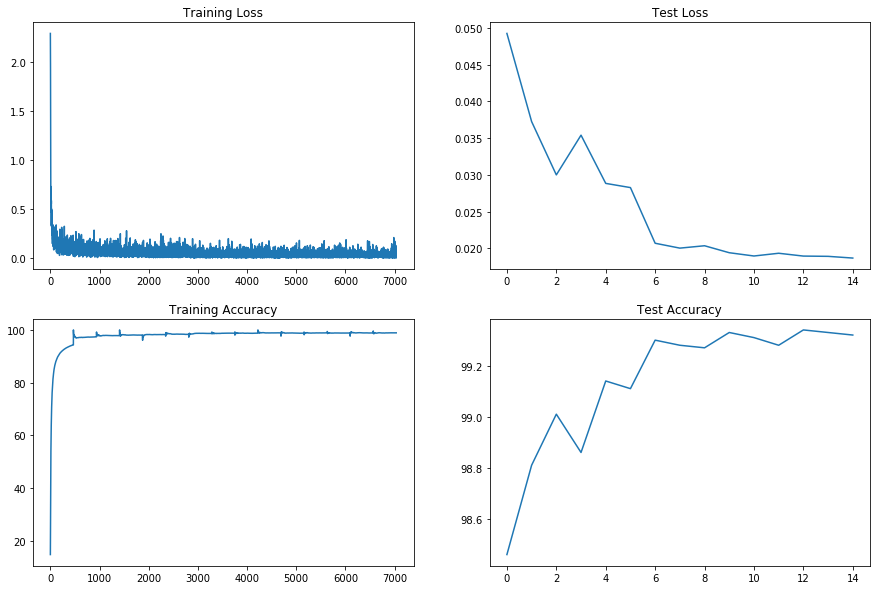

In [12]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")